<a href="https://colab.research.google.com/github/ShreyJ1729/EVA6-TSAI/blob/main/07-AdvancedConcepts/07-AdvancedConcepts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline


Training a Classifier
=====================

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

What about data?
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

1. Loading and normalizing CIFAR10
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Using ``torchvision``, it’s extremely easy to load CIFAR10.



In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [ ]:
!pip install -qq -U git+https://github.com/albu/albumentations --no-cache-dir
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import numpy as np

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])

image_transforms = A.Compose(
        [
            A.ShiftScaleRotate(
                shift_limit=0.05, scale_limit=0.05, rotate_limit=10, p=0.5
            ),
            A.HorizontalFlip(p=0.5),
            A.ToGray(p=0.25),
            A.CoarseDropout(max_holes=1, max_height=16, max_width=16, min_holes=1, min_height=1, min_width=1, fill_value=0.4733630004850904, mask_fill_value=None, p=0.5),
            A.Normalize(mean=(0.49139967861519745, 0.4821584083946076, 0.44653091444546616), std=(0.2470322324632823, 0.24348512800005553, 0.2615878417279641)),
            ToTensorV2(),
        ]
    )


trainset = torchvision.datasets.CIFAR10(
        root="./data",
        train=True,
        download=True,
        transform=lambda x: image_transforms(image=np.array(x))["image"],
    )


trainloader = torch.utils.data.DataLoader(trainset, batch_size=256,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=256,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Let us show some of the training images, for fun.



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 deer  ship   dog  frog


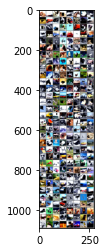

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

2. Define a Convolution Neural Network
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [ ]:
import torch.nn as nn
import torch.nn.functional as F
class Net(nn.Module):

    def __init__(self, dropout_value=0.01):

        self.dropout_value = dropout_value  # dropout value

        super(Net, self).__init__()

        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32,
                      kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(self.dropout_value)
        )  # output_size = 32

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64,
                      kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(self.dropout_value)
        )  # output_size = 32

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=32,
                      kernel_size=(1, 1), padding=0, stride=2, bias=False),
        )  # output_size = 16

        # CONVOLUTION BLOCK 2
        # DEPTHWISE CONVOLUTION AND POINTWISE CONVOLUTION
        self.depthwise1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32,
                      kernel_size=(3, 3), padding=1, groups=32, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(self.dropout_value)
        )  # output_size = 16
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64,
                      kernel_size=(1, 1), padding=0, stride=2, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(self.dropout_value)
        )  # output_size = 8

        # CONVOLUTION BLOCK 3
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128,
                      kernel_size=(3, 3), padding=4, dilation=2, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(self.dropout_value)
        )  # output_size = 11
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64,
                      kernel_size=(3, 3), padding=0, stride=2, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(self.dropout_value)
        )  # output_size = 5

        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=5)
        )  # output_size = 1

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=256,
                      kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Dropout(self.dropout_value)
        )

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=10,
                      kernel_size=(1, 1), padding=0, bias=False),
        )

        self.dropout = nn.Dropout(self.dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)

        x = self.depthwise1(x)
        x = self.convblock4(x)

        x = self.convblock5(x)
        x = self.convblock6(x)

        x = self.gap(x)
        x = self.convblock7(x)
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)


net = Net().to(device)

In [ ]:
!pip install torchsummary
from torchsummary import summary
summary(net, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          18,432
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
           Dropout-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 32, 16, 16]           2,048
           Conv2d-10           [-1, 32, 16, 16]             288
      BatchNorm2d-11           [-1, 32, 16, 16]              64
             ReLU-12           [-1, 32, 16, 16]               0
          Dropout-13           [-1, 32, 16, 16]               0
           Conv2d-14             [-1, 6

3. Define a Loss function and optimizer
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.9)

4. Train the network
^^^^^^^^^^^^^^^^^^^^

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [ ]:
import torch

def fit(model_name, model, device, train_loader, val_loader, optimizer, epochs, loss_func, scheduler=None, leave=False):
    model = model.to(device)

    results = {
        "train_acc": [],
        "test_acc": [],
    }

    for epoch in range(epochs):
        model.train()
        correct = 0

        for batch_idx, (data, target) in enumerate(tqdm(trainloader)):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = loss_func(output, target)

            loss.backward()
            optimizer.step()
            
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

        tqdm.write('\r[Epoch {}]\nTrain set: Accuracy: {}/{} ({:.2f}%)'.format(epoch, 
            correct, len(train_loader.dataset),
            100. * correct / len(train_loader.dataset)))
        
        results["train_acc"].append(100. * correct / len(train_loader.dataset))
        
        if scheduler is not None:
            scheduler.step(loss.item())

        # validation
        model.eval()
        test_loss = 0
        correct = 0
    
        with torch.no_grad():
            for data, target in testloader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                test_loss += loss_func(output, target).item()  # sum up batch loss
                pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
                correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(testloader.dataset)

        tqdm.write("Test set: Accuracy: {}/{} ({:.2f}%)\n".format(correct, len(testloader.dataset),
            100. * correct / len(testloader.dataset) )
        )

        results["test_acc"].append(100. * correct / len(testloader.dataset) )

        if results["test_acc"][-1] > 85:
          break
    
    torch.save(model, f"{model_name}.pt")
    return results

In [ ]:
# early stopping is implemented so train until 85% accuracy
results = fit("cifar10", net, device, trainloader, testloader, optimizer, 1000000, criterion, scheduler)


[Epoch 0]
Train set: Accuracy: 39459/50000 (78.92%)
Test set: Accuracy: 7788/10000 (77.88%)




[Epoch 1]
Train set: Accuracy: 39381/50000 (78.76%)
Test set: Accuracy: 7794/10000 (77.94%)




[Epoch 2]
Train set: Accuracy: 39523/50000 (79.05%)
Test set: Accuracy: 7875/10000 (78.75%)



Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbe9fbdf7a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbe9fbdf7a0>
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Traceback (most recent call last):
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho


[Epoch 3]
Train set: Accuracy: 39592/50000 (79.18%)
Test set: Accuracy: 7926/10000 (79.26%)



Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbe9fbdf7a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbe9fbdf7a0>
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho


[Epoch 4]
Train set: Accuracy: 39705/50000 (79.41%)
Test set: Accuracy: 7940/10000 (79.40%)



Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbe9fbdf7a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbe9fbdf7a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho


[Epoch 5]
Train set: Accuracy: 39636/50000 (79.27%)
Test set: Accuracy: 7847/10000 (78.47%)




[Epoch 6]
Train set: Accuracy: 39663/50000 (79.33%)
Test set: Accuracy: 7921/10000 (79.21%)




[Epoch 7]
Train set: Accuracy: 39678/50000 (79.36%)
Test set: Accuracy: 7946/10000 (79.46%)




[Epoch 8]
Train set: Accuracy: 39903/50000 (79.81%)
Test set: Accuracy: 7847/10000 (78.47%)




[Epoch 9]
Train set: Accuracy: 39867/50000 (79.73%)
Test set: Accuracy: 7953/10000 (79.53%)




[Epoch 10]
Train set: Accuracy: 39965/50000 (79.93%)
Test set: Accuracy: 7853/10000 (78.53%)




[Epoch 11]
Train set: Accuracy: 40016/50000 (80.03%)
Test set: Accuracy: 7946/10000 (79.46%)




[Epoch 12]
Train set: Accuracy: 40143/50000 (80.29%)
Test set: Accuracy: 7965/10000 (79.65%)




[Epoch 13]
Train set: Accuracy: 39903/50000 (79.81%)
Test set: Accuracy: 8049/10000 (80.49%)




[Epoch 14]
Train set: Accuracy: 40241/50000 (80.48%)
Test set: Accuracy: 7868/10000 (78.68%)




[Epoch 15]
Train set: Accuracy: 40294/50000 (80.59%)
Test set: Accuracy: 8012/10000 (80.12%)




[Epoch 16]
Train set: Accuracy: 40127/50000 (80.25%)
Test set: Accuracy: 7995/10000 (79.95%)




[Epoch 17]
Train set: Accuracy: 40280/50000 (80.56%)
Test set: Accuracy: 7698/10000 (76.98%)




[Epoch 18]
Train set: Accuracy: 40395/50000 (80.79%)
Test set: Accuracy: 7852/10000 (78.52%)




[Epoch 19]
Train set: Accuracy: 40456/50000 (80.91%)
Test set: Accuracy: 7995/10000 (79.95%)




[Epoch 20]
Train set: Accuracy: 40542/50000 (81.08%)
Test set: Accuracy: 7950/10000 (79.50%)




[Epoch 21]
Train set: Accuracy: 40508/50000 (81.02%)
Test set: Accuracy: 7866/10000 (78.66%)




[Epoch 22]
Train set: Accuracy: 40546/50000 (81.09%)
Test set: Accuracy: 7969/10000 (79.69%)




[Epoch 23]
Train set: Accuracy: 40596/50000 (81.19%)
Test set: Accuracy: 8037/10000 (80.37%)




[Epoch 24]
Train set: Accuracy: 40729/50000 (81.46%)
Test set: Accuracy: 8000/10000 (80.00%)




[Epoch 25]
Train set: Accuracy: 40696/50000 (81.39%)
Test set: Accuracy: 8046/10000 (80.46%)



Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbe9fbdf7a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbe9fbdf7a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child


[Epoch 26]
Train set: Accuracy: 40897/50000 (81.79%)
Test set: Accuracy: 7928/10000 (79.28%)



Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbe9fbdf7a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbe9fbdf7a0>
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Traceback (most recent call last):
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho


[Epoch 27]
Train set: Accuracy: 40858/50000 (81.72%)
Test set: Accuracy: 8038/10000 (80.38%)



Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbe9fbdf7a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbe9fbdf7a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho


[Epoch 28]
Train set: Accuracy: 40791/50000 (81.58%)
Test set: Accuracy: 8074/10000 (80.74%)



Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbe9fbdf7a0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbe9fbdf7a0>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho


[Epoch 29]
Train set: Accuracy: 40819/50000 (81.64%)


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbe9fbdf7a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbe9fbdf7a0>
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Traceback (most recent call last):
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Test set: Accuracy: 8070/10000 (80.70%)



Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbe9fbdf7a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbe9fbdf7a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho


[Epoch 30]
Train set: Accuracy: 40957/50000 (81.91%)


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbe9fbdf7a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbe9fbdf7a0>
AssertionError: can only test a child process
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Test set: Accuracy: 8137/10000 (81.37%)



Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbe9fbdf7a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbe9fbdf7a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho


[Epoch 31]
Train set: Accuracy: 40870/50000 (81.74%)
Test set: Accuracy: 8048/10000 (80.48%)




[Epoch 32]
Train set: Accuracy: 40921/50000 (81.84%)
Test set: Accuracy: 8069/10000 (80.69%)




[Epoch 33]
Train set: Accuracy: 41021/50000 (82.04%)
Test set: Accuracy: 8042/10000 (80.42%)




[Epoch 34]
Train set: Accuracy: 41136/50000 (82.27%)
Test set: Accuracy: 7961/10000 (79.61%)




[Epoch 35]
Train set: Accuracy: 41115/50000 (82.23%)
Test set: Accuracy: 8047/10000 (80.47%)




[Epoch 36]
Train set: Accuracy: 41158/50000 (82.32%)
Test set: Accuracy: 8098/10000 (80.98%)




[Epoch 37]
Train set: Accuracy: 41301/50000 (82.60%)
Test set: Accuracy: 8137/10000 (81.37%)




[Epoch 38]
Train set: Accuracy: 41141/50000 (82.28%)
Test set: Accuracy: 7988/10000 (79.88%)




[Epoch 39]
Train set: Accuracy: 41133/50000 (82.27%)
Test set: Accuracy: 8058/10000 (80.58%)




[Epoch 40]
Train set: Accuracy: 41375/50000 (82.75%)
Test set: Accuracy: 8076/10000 (80.76%)




[Epoch 41]
Train set: Accuracy: 41340/50000 (82.68%)
Test set: Accuracy: 8032/10000 (80.32%)




[Epoch 42]
Train set: Accuracy: 41496/50000 (82.99%)
Test set: Accuracy: 8031/10000 (80.31%)




[Epoch 43]
Train set: Accuracy: 41566/50000 (83.13%)
Test set: Accuracy: 8142/10000 (81.42%)




[Epoch 44]
Train set: Accuracy: 41527/50000 (83.05%)
Test set: Accuracy: 8102/10000 (81.02%)




[Epoch 45]
Train set: Accuracy: 41672/50000 (83.34%)
Test set: Accuracy: 8137/10000 (81.37%)




[Epoch 46]
Train set: Accuracy: 41601/50000 (83.20%)
Test set: Accuracy: 8179/10000 (81.79%)




[Epoch 47]
Train set: Accuracy: 41629/50000 (83.26%)
Test set: Accuracy: 8146/10000 (81.46%)




[Epoch 48]
Train set: Accuracy: 41585/50000 (83.17%)
Test set: Accuracy: 8094/10000 (80.94%)




[Epoch 49]
Train set: Accuracy: 41709/50000 (83.42%)
Test set: Accuracy: 8122/10000 (81.22%)




[Epoch 50]
Train set: Accuracy: 41668/50000 (83.34%)
Test set: Accuracy: 8167/10000 (81.67%)




[Epoch 51]
Train set: Accuracy: 41779/50000 (83.56%)
Test set: Accuracy: 8108/10000 (81.08%)




[Epoch 52]
Train set: Accuracy: 41884/50000 (83.77%)
Test set: Accuracy: 8143/10000 (81.43%)




[Epoch 53]
Train set: Accuracy: 41933/50000 (83.87%)
Test set: Accuracy: 8158/10000 (81.58%)




[Epoch 54]
Train set: Accuracy: 41900/50000 (83.80%)
Test set: Accuracy: 8108/10000 (81.08%)




[Epoch 55]
Train set: Accuracy: 41885/50000 (83.77%)
Test set: Accuracy: 8180/10000 (81.80%)




[Epoch 56]
Train set: Accuracy: 41846/50000 (83.69%)
Test set: Accuracy: 8148/10000 (81.48%)




[Epoch 57]
Train set: Accuracy: 41837/50000 (83.67%)
Test set: Accuracy: 8166/10000 (81.66%)




[Epoch 58]
Train set: Accuracy: 41946/50000 (83.89%)
Test set: Accuracy: 8166/10000 (81.66%)




[Epoch 59]
Train set: Accuracy: 42120/50000 (84.24%)
Test set: Accuracy: 8194/10000 (81.94%)




[Epoch 60]
Train set: Accuracy: 42055/50000 (84.11%)
Test set: Accuracy: 8144/10000 (81.44%)




[Epoch 61]
Train set: Accuracy: 42044/50000 (84.09%)
Test set: Accuracy: 8147/10000 (81.47%)




[Epoch 62]
Train set: Accuracy: 42240/50000 (84.48%)
Test set: Accuracy: 8220/10000 (82.20%)




[Epoch 63]
Train set: Accuracy: 42263/50000 (84.53%)
Test set: Accuracy: 8125/10000 (81.25%)




[Epoch 64]
Train set: Accuracy: 42104/50000 (84.21%)
Test set: Accuracy: 8210/10000 (82.10%)




[Epoch 65]
Train set: Accuracy: 42348/50000 (84.70%)
Test set: Accuracy: 8202/10000 (82.02%)




[Epoch 66]
Train set: Accuracy: 42276/50000 (84.55%)
Test set: Accuracy: 8253/10000 (82.53%)




[Epoch 67]
Train set: Accuracy: 42315/50000 (84.63%)
Test set: Accuracy: 8139/10000 (81.39%)




[Epoch 68]
Train set: Accuracy: 42328/50000 (84.66%)
Test set: Accuracy: 8223/10000 (82.23%)




[Epoch 69]
Train set: Accuracy: 42315/50000 (84.63%)
Test set: Accuracy: 8157/10000 (81.57%)




[Epoch 70]
Train set: Accuracy: 42326/50000 (84.65%)
Test set: Accuracy: 8189/10000 (81.89%)




[Epoch 71]
Train set: Accuracy: 42404/50000 (84.81%)
Test set: Accuracy: 8124/10000 (81.24%)




[Epoch 72]
Train set: Accuracy: 42256/50000 (84.51%)
Test set: Accuracy: 8198/10000 (81.98%)




[Epoch 73]
Train set: Accuracy: 42582/50000 (85.16%)
Test set: Accuracy: 8201/10000 (82.01%)




[Epoch 74]
Train set: Accuracy: 42522/50000 (85.04%)
Test set: Accuracy: 8245/10000 (82.45%)




[Epoch 75]
Train set: Accuracy: 42548/50000 (85.10%)
Test set: Accuracy: 8193/10000 (81.93%)




[Epoch 76]
Train set: Accuracy: 42729/50000 (85.46%)
Test set: Accuracy: 8264/10000 (82.64%)




[Epoch 77]
Train set: Accuracy: 42641/50000 (85.28%)
Test set: Accuracy: 8170/10000 (81.70%)




[Epoch 78]
Train set: Accuracy: 42579/50000 (85.16%)
Test set: Accuracy: 8262/10000 (82.62%)




[Epoch 79]
Train set: Accuracy: 42592/50000 (85.18%)
Test set: Accuracy: 8193/10000 (81.93%)




[Epoch 80]
Train set: Accuracy: 42535/50000 (85.07%)
Test set: Accuracy: 8218/10000 (82.18%)




[Epoch 81]
Train set: Accuracy: 42668/50000 (85.34%)
Test set: Accuracy: 8217/10000 (82.17%)




[Epoch 82]
Train set: Accuracy: 42474/50000 (84.95%)
Test set: Accuracy: 8196/10000 (81.96%)




[Epoch 83]
Train set: Accuracy: 42649/50000 (85.30%)
Test set: Accuracy: 8162/10000 (81.62%)




[Epoch 84]
Train set: Accuracy: 42650/50000 (85.30%)
Test set: Accuracy: 8265/10000 (82.65%)




[Epoch 85]
Train set: Accuracy: 42688/50000 (85.38%)
Test set: Accuracy: 8274/10000 (82.74%)




[Epoch 86]
Train set: Accuracy: 42794/50000 (85.59%)
Test set: Accuracy: 8218/10000 (82.18%)




[Epoch 87]
Train set: Accuracy: 42758/50000 (85.52%)
Test set: Accuracy: 8234/10000 (82.34%)




[Epoch 88]
Train set: Accuracy: 42891/50000 (85.78%)
Test set: Accuracy: 8261/10000 (82.61%)




[Epoch 89]
Train set: Accuracy: 42870/50000 (85.74%)
Test set: Accuracy: 8230/10000 (82.30%)




[Epoch 90]
Train set: Accuracy: 42780/50000 (85.56%)
Test set: Accuracy: 8279/10000 (82.79%)




[Epoch 91]
Train set: Accuracy: 42857/50000 (85.71%)
Test set: Accuracy: 8275/10000 (82.75%)




[Epoch 92]
Train set: Accuracy: 42904/50000 (85.81%)
Test set: Accuracy: 8234/10000 (82.34%)




[Epoch 93]
Train set: Accuracy: 42941/50000 (85.88%)
Test set: Accuracy: 8237/10000 (82.37%)




[Epoch 94]
Train set: Accuracy: 42969/50000 (85.94%)
Test set: Accuracy: 8248/10000 (82.48%)




[Epoch 95]
Train set: Accuracy: 43016/50000 (86.03%)
Test set: Accuracy: 8256/10000 (82.56%)




[Epoch 96]
Train set: Accuracy: 42926/50000 (85.85%)
Test set: Accuracy: 8270/10000 (82.70%)




[Epoch 97]
Train set: Accuracy: 43048/50000 (86.10%)
Test set: Accuracy: 8231/10000 (82.31%)




[Epoch 98]
Train set: Accuracy: 43044/50000 (86.09%)
Test set: Accuracy: 8221/10000 (82.21%)




[Epoch 99]
Train set: Accuracy: 43046/50000 (86.09%)
Test set: Accuracy: 8257/10000 (82.57%)




[Epoch 100]
Train set: Accuracy: 42921/50000 (85.84%)
Test set: Accuracy: 8276/10000 (82.76%)




[Epoch 101]
Train set: Accuracy: 43058/50000 (86.12%)
Test set: Accuracy: 8293/10000 (82.93%)




[Epoch 102]
Train set: Accuracy: 43211/50000 (86.42%)
Test set: Accuracy: 8252/10000 (82.52%)




[Epoch 103]
Train set: Accuracy: 43108/50000 (86.22%)
Test set: Accuracy: 8294/10000 (82.94%)




[Epoch 104]
Train set: Accuracy: 43215/50000 (86.43%)
Test set: Accuracy: 8266/10000 (82.66%)




[Epoch 105]
Train set: Accuracy: 43192/50000 (86.38%)
Test set: Accuracy: 8259/10000 (82.59%)




[Epoch 106]
Train set: Accuracy: 43063/50000 (86.13%)
Test set: Accuracy: 8250/10000 (82.50%)




[Epoch 107]
Train set: Accuracy: 43038/50000 (86.08%)
Test set: Accuracy: 8288/10000 (82.88%)




[Epoch 108]
Train set: Accuracy: 43141/50000 (86.28%)
Test set: Accuracy: 8251/10000 (82.51%)




[Epoch 109]
Train set: Accuracy: 43101/50000 (86.20%)
Test set: Accuracy: 8256/10000 (82.56%)




[Epoch 110]
Train set: Accuracy: 43053/50000 (86.11%)
Test set: Accuracy: 8280/10000 (82.80%)




[Epoch 111]
Train set: Accuracy: 43206/50000 (86.41%)
Test set: Accuracy: 8293/10000 (82.93%)




[Epoch 112]
Train set: Accuracy: 43123/50000 (86.25%)
Test set: Accuracy: 8250/10000 (82.50%)




[Epoch 113]
Train set: Accuracy: 43228/50000 (86.46%)
Test set: Accuracy: 8289/10000 (82.89%)




[Epoch 114]
Train set: Accuracy: 43196/50000 (86.39%)
Test set: Accuracy: 8262/10000 (82.62%)




[Epoch 115]
Train set: Accuracy: 43246/50000 (86.49%)
Test set: Accuracy: 8293/10000 (82.93%)




[Epoch 116]
Train set: Accuracy: 43330/50000 (86.66%)
Test set: Accuracy: 8240/10000 (82.40%)




[Epoch 117]
Train set: Accuracy: 43323/50000 (86.65%)
Test set: Accuracy: 8196/10000 (81.96%)




[Epoch 118]
Train set: Accuracy: 43232/50000 (86.46%)
Test set: Accuracy: 8263/10000 (82.63%)




[Epoch 119]
Train set: Accuracy: 43257/50000 (86.51%)
Test set: Accuracy: 8293/10000 (82.93%)




[Epoch 120]
Train set: Accuracy: 43421/50000 (86.84%)
Test set: Accuracy: 8255/10000 (82.55%)




[Epoch 121]
Train set: Accuracy: 43332/50000 (86.66%)
Test set: Accuracy: 8280/10000 (82.80%)




[Epoch 122]
Train set: Accuracy: 43365/50000 (86.73%)
Test set: Accuracy: 8280/10000 (82.80%)




[Epoch 123]
Train set: Accuracy: 43345/50000 (86.69%)
Test set: Accuracy: 8351/10000 (83.51%)




[Epoch 124]
Train set: Accuracy: 43386/50000 (86.77%)
Test set: Accuracy: 8314/10000 (83.14%)




[Epoch 125]
Train set: Accuracy: 43342/50000 (86.68%)
Test set: Accuracy: 8341/10000 (83.41%)




[Epoch 126]
Train set: Accuracy: 43401/50000 (86.80%)
Test set: Accuracy: 8310/10000 (83.10%)




[Epoch 127]
Train set: Accuracy: 43528/50000 (87.06%)
Test set: Accuracy: 8300/10000 (83.00%)




[Epoch 128]
Train set: Accuracy: 43522/50000 (87.04%)
Test set: Accuracy: 8312/10000 (83.12%)




[Epoch 129]
Train set: Accuracy: 43524/50000 (87.05%)
Test set: Accuracy: 8296/10000 (82.96%)




[Epoch 130]
Train set: Accuracy: 43467/50000 (86.93%)
Test set: Accuracy: 8252/10000 (82.52%)




[Epoch 131]
Train set: Accuracy: 43487/50000 (86.97%)
Test set: Accuracy: 8324/10000 (83.24%)




[Epoch 132]
Train set: Accuracy: 43528/50000 (87.06%)
Test set: Accuracy: 8312/10000 (83.12%)




[Epoch 133]
Train set: Accuracy: 43489/50000 (86.98%)
Test set: Accuracy: 8303/10000 (83.03%)




[Epoch 134]
Train set: Accuracy: 43594/50000 (87.19%)
Test set: Accuracy: 8285/10000 (82.85%)




[Epoch 135]
Train set: Accuracy: 43415/50000 (86.83%)
Test set: Accuracy: 8316/10000 (83.16%)




[Epoch 136]
Train set: Accuracy: 43582/50000 (87.16%)
Test set: Accuracy: 8285/10000 (82.85%)




[Epoch 137]
Train set: Accuracy: 43700/50000 (87.40%)
Test set: Accuracy: 8292/10000 (82.92%)




[Epoch 138]
Train set: Accuracy: 43661/50000 (87.32%)
Test set: Accuracy: 8308/10000 (83.08%)




[Epoch 139]
Train set: Accuracy: 43658/50000 (87.32%)
Test set: Accuracy: 8330/10000 (83.30%)




[Epoch 140]
Train set: Accuracy: 43668/50000 (87.34%)
Test set: Accuracy: 8319/10000 (83.19%)




[Epoch 141]
Train set: Accuracy: 43579/50000 (87.16%)
Test set: Accuracy: 8337/10000 (83.37%)




[Epoch 142]
Train set: Accuracy: 43513/50000 (87.03%)
Test set: Accuracy: 8310/10000 (83.10%)




[Epoch 143]
Train set: Accuracy: 43719/50000 (87.44%)
Test set: Accuracy: 8330/10000 (83.30%)




[Epoch 144]
Train set: Accuracy: 43641/50000 (87.28%)
Test set: Accuracy: 8291/10000 (82.91%)




[Epoch 145]
Train set: Accuracy: 43783/50000 (87.57%)
Test set: Accuracy: 8331/10000 (83.31%)




[Epoch 146]
Train set: Accuracy: 43596/50000 (87.19%)
Test set: Accuracy: 8342/10000 (83.42%)




[Epoch 147]
Train set: Accuracy: 43702/50000 (87.40%)
Test set: Accuracy: 8333/10000 (83.33%)




[Epoch 148]
Train set: Accuracy: 43760/50000 (87.52%)
Test set: Accuracy: 8334/10000 (83.34%)




[Epoch 149]
Train set: Accuracy: 43643/50000 (87.29%)
Test set: Accuracy: 8310/10000 (83.10%)




[Epoch 150]
Train set: Accuracy: 43814/50000 (87.63%)
Test set: Accuracy: 8307/10000 (83.07%)




[Epoch 151]
Train set: Accuracy: 43802/50000 (87.60%)
Test set: Accuracy: 8308/10000 (83.08%)




[Epoch 152]
Train set: Accuracy: 43758/50000 (87.52%)
Test set: Accuracy: 8347/10000 (83.47%)




[Epoch 153]
Train set: Accuracy: 43675/50000 (87.35%)
Test set: Accuracy: 8329/10000 (83.29%)




[Epoch 154]
Train set: Accuracy: 43834/50000 (87.67%)
Test set: Accuracy: 8363/10000 (83.63%)




[Epoch 155]
Train set: Accuracy: 43745/50000 (87.49%)
Test set: Accuracy: 8295/10000 (82.95%)




[Epoch 156]
Train set: Accuracy: 43844/50000 (87.69%)
Test set: Accuracy: 8362/10000 (83.62%)




[Epoch 157]
Train set: Accuracy: 43863/50000 (87.73%)
Test set: Accuracy: 8325/10000 (83.25%)




[Epoch 158]
Train set: Accuracy: 43756/50000 (87.51%)
Test set: Accuracy: 8314/10000 (83.14%)




[Epoch 159]
Train set: Accuracy: 43768/50000 (87.54%)
Test set: Accuracy: 8314/10000 (83.14%)




[Epoch 160]
Train set: Accuracy: 43819/50000 (87.64%)
Test set: Accuracy: 8295/10000 (82.95%)




[Epoch 161]
Train set: Accuracy: 43839/50000 (87.68%)
Test set: Accuracy: 8328/10000 (83.28%)




[Epoch 162]
Train set: Accuracy: 43789/50000 (87.58%)
Test set: Accuracy: 8291/10000 (82.91%)




[Epoch 163]
Train set: Accuracy: 43808/50000 (87.62%)
Test set: Accuracy: 8287/10000 (82.87%)




[Epoch 164]
Train set: Accuracy: 43863/50000 (87.73%)
Test set: Accuracy: 8325/10000 (83.25%)




[Epoch 165]
Train set: Accuracy: 43929/50000 (87.86%)
Test set: Accuracy: 8333/10000 (83.33%)




[Epoch 166]
Train set: Accuracy: 43876/50000 (87.75%)
Test set: Accuracy: 8304/10000 (83.04%)




[Epoch 167]
Train set: Accuracy: 43864/50000 (87.73%)
Test set: Accuracy: 8314/10000 (83.14%)




[Epoch 168]
Train set: Accuracy: 43918/50000 (87.84%)
Test set: Accuracy: 8331/10000 (83.31%)




[Epoch 169]
Train set: Accuracy: 43877/50000 (87.75%)
Test set: Accuracy: 8298/10000 (82.98%)




[Epoch 170]
Train set: Accuracy: 43859/50000 (87.72%)
Test set: Accuracy: 8312/10000 (83.12%)




[Epoch 171]
Train set: Accuracy: 43908/50000 (87.82%)
Test set: Accuracy: 8329/10000 (83.29%)




[Epoch 172]
Train set: Accuracy: 43931/50000 (87.86%)
Test set: Accuracy: 8347/10000 (83.47%)




[Epoch 173]
Train set: Accuracy: 43860/50000 (87.72%)
Test set: Accuracy: 8307/10000 (83.07%)




[Epoch 174]
Train set: Accuracy: 43906/50000 (87.81%)
Test set: Accuracy: 8311/10000 (83.11%)




[Epoch 175]
Train set: Accuracy: 43896/50000 (87.79%)
Test set: Accuracy: 8341/10000 (83.41%)




[Epoch 176]
Train set: Accuracy: 43896/50000 (87.79%)
Test set: Accuracy: 8356/10000 (83.56%)




[Epoch 177]
Train set: Accuracy: 44027/50000 (88.05%)
Test set: Accuracy: 8330/10000 (83.30%)




[Epoch 178]
Train set: Accuracy: 43965/50000 (87.93%)
Test set: Accuracy: 8341/10000 (83.41%)




[Epoch 179]
Train set: Accuracy: 43991/50000 (87.98%)
Test set: Accuracy: 8329/10000 (83.29%)




[Epoch 180]
Train set: Accuracy: 44121/50000 (88.24%)
Test set: Accuracy: 8331/10000 (83.31%)




[Epoch 181]
Train set: Accuracy: 44078/50000 (88.16%)
Test set: Accuracy: 8384/10000 (83.84%)




[Epoch 182]
Train set: Accuracy: 44055/50000 (88.11%)
Test set: Accuracy: 8338/10000 (83.38%)




[Epoch 183]
Train set: Accuracy: 44039/50000 (88.08%)
Test set: Accuracy: 8345/10000 (83.45%)




[Epoch 184]
Train set: Accuracy: 44030/50000 (88.06%)
Test set: Accuracy: 8353/10000 (83.53%)




[Epoch 185]
Train set: Accuracy: 44082/50000 (88.16%)
Test set: Accuracy: 8315/10000 (83.15%)




[Epoch 186]
Train set: Accuracy: 44072/50000 (88.14%)
Test set: Accuracy: 8331/10000 (83.31%)




[Epoch 187]
Train set: Accuracy: 44125/50000 (88.25%)
Test set: Accuracy: 8312/10000 (83.12%)




[Epoch 188]
Train set: Accuracy: 44081/50000 (88.16%)
Test set: Accuracy: 8368/10000 (83.68%)




[Epoch 189]
Train set: Accuracy: 44082/50000 (88.16%)
Test set: Accuracy: 8341/10000 (83.41%)




[Epoch 190]
Train set: Accuracy: 44171/50000 (88.34%)
Test set: Accuracy: 8327/10000 (83.27%)




[Epoch 191]
Train set: Accuracy: 44141/50000 (88.28%)
Test set: Accuracy: 8357/10000 (83.57%)




[Epoch 192]
Train set: Accuracy: 44061/50000 (88.12%)
Test set: Accuracy: 8383/10000 (83.83%)




[Epoch 193]
Train set: Accuracy: 44047/50000 (88.09%)
Test set: Accuracy: 8366/10000 (83.66%)




[Epoch 194]
Train set: Accuracy: 44170/50000 (88.34%)
Test set: Accuracy: 8344/10000 (83.44%)




[Epoch 195]
Train set: Accuracy: 44169/50000 (88.34%)
Test set: Accuracy: 8350/10000 (83.50%)




[Epoch 196]
Train set: Accuracy: 44104/50000 (88.21%)
Test set: Accuracy: 8361/10000 (83.61%)




[Epoch 197]
Train set: Accuracy: 44220/50000 (88.44%)
Test set: Accuracy: 8375/10000 (83.75%)




[Epoch 198]
Train set: Accuracy: 44062/50000 (88.12%)
Test set: Accuracy: 8340/10000 (83.40%)




[Epoch 199]
Train set: Accuracy: 44097/50000 (88.19%)
Test set: Accuracy: 8326/10000 (83.26%)




[Epoch 200]
Train set: Accuracy: 44243/50000 (88.49%)
Test set: Accuracy: 8345/10000 (83.45%)




[Epoch 201]
Train set: Accuracy: 44245/50000 (88.49%)
Test set: Accuracy: 8349/10000 (83.49%)




[Epoch 202]
Train set: Accuracy: 44261/50000 (88.52%)
Test set: Accuracy: 8363/10000 (83.63%)




[Epoch 203]
Train set: Accuracy: 44133/50000 (88.27%)
Test set: Accuracy: 8350/10000 (83.50%)




[Epoch 204]
Train set: Accuracy: 44335/50000 (88.67%)
Test set: Accuracy: 8363/10000 (83.63%)




[Epoch 205]
Train set: Accuracy: 44131/50000 (88.26%)
Test set: Accuracy: 8377/10000 (83.77%)




[Epoch 206]
Train set: Accuracy: 44224/50000 (88.45%)
Test set: Accuracy: 8366/10000 (83.66%)




[Epoch 207]
Train set: Accuracy: 44212/50000 (88.42%)
Test set: Accuracy: 8353/10000 (83.53%)




[Epoch 208]
Train set: Accuracy: 44358/50000 (88.72%)
Test set: Accuracy: 8345/10000 (83.45%)




[Epoch 209]
Train set: Accuracy: 44133/50000 (88.27%)
Test set: Accuracy: 8333/10000 (83.33%)




[Epoch 210]
Train set: Accuracy: 44277/50000 (88.55%)
Test set: Accuracy: 8364/10000 (83.64%)




[Epoch 211]
Train set: Accuracy: 44333/50000 (88.67%)
Test set: Accuracy: 8352/10000 (83.52%)




[Epoch 212]
Train set: Accuracy: 44308/50000 (88.62%)
Test set: Accuracy: 8361/10000 (83.61%)




[Epoch 213]
Train set: Accuracy: 44296/50000 (88.59%)
Test set: Accuracy: 8359/10000 (83.59%)




[Epoch 214]
Train set: Accuracy: 44271/50000 (88.54%)
Test set: Accuracy: 8383/10000 (83.83%)




[Epoch 215]
Train set: Accuracy: 44243/50000 (88.49%)
Test set: Accuracy: 8334/10000 (83.34%)




[Epoch 216]
Train set: Accuracy: 44412/50000 (88.82%)
Test set: Accuracy: 8372/10000 (83.72%)




[Epoch 217]
Train set: Accuracy: 44339/50000 (88.68%)
Test set: Accuracy: 8376/10000 (83.76%)




[Epoch 218]
Train set: Accuracy: 44338/50000 (88.68%)
Test set: Accuracy: 8378/10000 (83.78%)




[Epoch 219]
Train set: Accuracy: 44329/50000 (88.66%)
Test set: Accuracy: 8362/10000 (83.62%)




[Epoch 220]
Train set: Accuracy: 44366/50000 (88.73%)
Test set: Accuracy: 8368/10000 (83.68%)




[Epoch 221]
Train set: Accuracy: 44345/50000 (88.69%)
Test set: Accuracy: 8364/10000 (83.64%)




[Epoch 222]
Train set: Accuracy: 44341/50000 (88.68%)
Test set: Accuracy: 8345/10000 (83.45%)




[Epoch 223]
Train set: Accuracy: 44435/50000 (88.87%)
Test set: Accuracy: 8356/10000 (83.56%)




[Epoch 224]
Train set: Accuracy: 44249/50000 (88.50%)
Test set: Accuracy: 8354/10000 (83.54%)




[Epoch 225]
Train set: Accuracy: 44453/50000 (88.91%)
Test set: Accuracy: 8365/10000 (83.65%)




[Epoch 226]
Train set: Accuracy: 44427/50000 (88.85%)
Test set: Accuracy: 8375/10000 (83.75%)




[Epoch 227]
Train set: Accuracy: 44341/50000 (88.68%)
Test set: Accuracy: 8365/10000 (83.65%)




[Epoch 228]
Train set: Accuracy: 44334/50000 (88.67%)
Test set: Accuracy: 8394/10000 (83.94%)




[Epoch 229]
Train set: Accuracy: 44368/50000 (88.74%)
Test set: Accuracy: 8377/10000 (83.77%)




[Epoch 230]
Train set: Accuracy: 44179/50000 (88.36%)
Test set: Accuracy: 8393/10000 (83.93%)




[Epoch 231]
Train set: Accuracy: 44409/50000 (88.82%)
Test set: Accuracy: 8395/10000 (83.95%)




[Epoch 232]
Train set: Accuracy: 44426/50000 (88.85%)
Test set: Accuracy: 8374/10000 (83.74%)




[Epoch 233]
Train set: Accuracy: 44370/50000 (88.74%)
Test set: Accuracy: 8380/10000 (83.80%)




[Epoch 234]
Train set: Accuracy: 44444/50000 (88.89%)
Test set: Accuracy: 8380/10000 (83.80%)




[Epoch 235]
Train set: Accuracy: 44360/50000 (88.72%)
Test set: Accuracy: 8377/10000 (83.77%)




[Epoch 236]
Train set: Accuracy: 44356/50000 (88.71%)
Test set: Accuracy: 8362/10000 (83.62%)




[Epoch 237]
Train set: Accuracy: 44324/50000 (88.65%)
Test set: Accuracy: 8356/10000 (83.56%)




[Epoch 238]
Train set: Accuracy: 44374/50000 (88.75%)
Test set: Accuracy: 8381/10000 (83.81%)




[Epoch 239]
Train set: Accuracy: 44347/50000 (88.69%)
Test set: Accuracy: 8372/10000 (83.72%)




[Epoch 240]
Train set: Accuracy: 44386/50000 (88.77%)
Test set: Accuracy: 8359/10000 (83.59%)




[Epoch 241]
Train set: Accuracy: 44467/50000 (88.93%)
Test set: Accuracy: 8357/10000 (83.57%)




[Epoch 242]
Train set: Accuracy: 44463/50000 (88.93%)
Test set: Accuracy: 8379/10000 (83.79%)




[Epoch 243]
Train set: Accuracy: 44407/50000 (88.81%)
Test set: Accuracy: 8392/10000 (83.92%)




[Epoch 244]
Train set: Accuracy: 44452/50000 (88.90%)
Test set: Accuracy: 8376/10000 (83.76%)




[Epoch 245]
Train set: Accuracy: 44333/50000 (88.67%)
Test set: Accuracy: 8373/10000 (83.73%)




[Epoch 246]
Train set: Accuracy: 44514/50000 (89.03%)
Test set: Accuracy: 8366/10000 (83.66%)




[Epoch 247]
Train set: Accuracy: 44402/50000 (88.80%)
Test set: Accuracy: 8354/10000 (83.54%)




[Epoch 248]
Train set: Accuracy: 44470/50000 (88.94%)
Test set: Accuracy: 8375/10000 (83.75%)




[Epoch 249]
Train set: Accuracy: 44418/50000 (88.84%)
Test set: Accuracy: 8381/10000 (83.81%)




[Epoch 250]
Train set: Accuracy: 44469/50000 (88.94%)
Test set: Accuracy: 8361/10000 (83.61%)




[Epoch 251]
Train set: Accuracy: 44440/50000 (88.88%)
Test set: Accuracy: 8371/10000 (83.71%)




[Epoch 252]
Train set: Accuracy: 44377/50000 (88.75%)
Test set: Accuracy: 8384/10000 (83.84%)




[Epoch 253]
Train set: Accuracy: 44378/50000 (88.76%)
Test set: Accuracy: 8362/10000 (83.62%)




[Epoch 254]
Train set: Accuracy: 44474/50000 (88.95%)
Test set: Accuracy: 8359/10000 (83.59%)




[Epoch 255]
Train set: Accuracy: 44459/50000 (88.92%)
Test set: Accuracy: 8383/10000 (83.83%)




[Epoch 256]
Train set: Accuracy: 44494/50000 (88.99%)
Test set: Accuracy: 8374/10000 (83.74%)




[Epoch 257]
Train set: Accuracy: 44465/50000 (88.93%)
Test set: Accuracy: 8389/10000 (83.89%)




[Epoch 258]
Train set: Accuracy: 44503/50000 (89.01%)
Test set: Accuracy: 8393/10000 (83.93%)




[Epoch 259]
Train set: Accuracy: 44377/50000 (88.75%)
Test set: Accuracy: 8354/10000 (83.54%)




[Epoch 260]
Train set: Accuracy: 44388/50000 (88.78%)
Test set: Accuracy: 8387/10000 (83.87%)




[Epoch 261]
Train set: Accuracy: 44517/50000 (89.03%)
Test set: Accuracy: 8373/10000 (83.73%)




[Epoch 262]
Train set: Accuracy: 44521/50000 (89.04%)
Test set: Accuracy: 8378/10000 (83.78%)




[Epoch 263]
Train set: Accuracy: 44562/50000 (89.12%)
Test set: Accuracy: 8358/10000 (83.58%)




[Epoch 264]
Train set: Accuracy: 44499/50000 (89.00%)
Test set: Accuracy: 8355/10000 (83.55%)




[Epoch 265]
Train set: Accuracy: 44516/50000 (89.03%)
Test set: Accuracy: 8342/10000 (83.42%)




[Epoch 266]
Train set: Accuracy: 44553/50000 (89.11%)
Test set: Accuracy: 8375/10000 (83.75%)




[Epoch 267]
Train set: Accuracy: 44529/50000 (89.06%)
Test set: Accuracy: 8390/10000 (83.90%)




[Epoch 268]
Train set: Accuracy: 44536/50000 (89.07%)
Test set: Accuracy: 8384/10000 (83.84%)




[Epoch 269]
Train set: Accuracy: 44625/50000 (89.25%)
Test set: Accuracy: 8401/10000 (84.01%)




[Epoch 270]
Train set: Accuracy: 44624/50000 (89.25%)
Test set: Accuracy: 8367/10000 (83.67%)




[Epoch 271]
Train set: Accuracy: 44457/50000 (88.91%)
Test set: Accuracy: 8352/10000 (83.52%)




[Epoch 272]
Train set: Accuracy: 44571/50000 (89.14%)
Test set: Accuracy: 8351/10000 (83.51%)




[Epoch 273]
Train set: Accuracy: 44541/50000 (89.08%)
Test set: Accuracy: 8382/10000 (83.82%)




[Epoch 274]
Train set: Accuracy: 44585/50000 (89.17%)
Test set: Accuracy: 8384/10000 (83.84%)




[Epoch 275]
Train set: Accuracy: 44487/50000 (88.97%)
Test set: Accuracy: 8394/10000 (83.94%)




[Epoch 276]
Train set: Accuracy: 44559/50000 (89.12%)
Test set: Accuracy: 8364/10000 (83.64%)




[Epoch 277]
Train set: Accuracy: 44561/50000 (89.12%)
Test set: Accuracy: 8380/10000 (83.80%)




[Epoch 278]
Train set: Accuracy: 44734/50000 (89.47%)
Test set: Accuracy: 8372/10000 (83.72%)




[Epoch 279]
Train set: Accuracy: 44660/50000 (89.32%)
Test set: Accuracy: 8365/10000 (83.65%)




[Epoch 280]
Train set: Accuracy: 44535/50000 (89.07%)
Test set: Accuracy: 8372/10000 (83.72%)




[Epoch 281]
Train set: Accuracy: 44666/50000 (89.33%)
Test set: Accuracy: 8381/10000 (83.81%)




[Epoch 282]
Train set: Accuracy: 44628/50000 (89.26%)
Test set: Accuracy: 8373/10000 (83.73%)




[Epoch 283]
Train set: Accuracy: 44620/50000 (89.24%)
Test set: Accuracy: 8376/10000 (83.76%)




[Epoch 284]
Train set: Accuracy: 44568/50000 (89.14%)
Test set: Accuracy: 8362/10000 (83.62%)




[Epoch 285]
Train set: Accuracy: 44655/50000 (89.31%)
Test set: Accuracy: 8391/10000 (83.91%)




[Epoch 286]
Train set: Accuracy: 44623/50000 (89.25%)
Test set: Accuracy: 8382/10000 (83.82%)




[Epoch 287]
Train set: Accuracy: 44554/50000 (89.11%)
Test set: Accuracy: 8378/10000 (83.78%)




[Epoch 288]
Train set: Accuracy: 44717/50000 (89.43%)
Test set: Accuracy: 8387/10000 (83.87%)




[Epoch 289]
Train set: Accuracy: 44601/50000 (89.20%)
Test set: Accuracy: 8375/10000 (83.75%)




[Epoch 290]
Train set: Accuracy: 44614/50000 (89.23%)
Test set: Accuracy: 8380/10000 (83.80%)




[Epoch 291]
Train set: Accuracy: 44724/50000 (89.45%)
Test set: Accuracy: 8371/10000 (83.71%)




[Epoch 292]
Train set: Accuracy: 44673/50000 (89.35%)
Test set: Accuracy: 8380/10000 (83.80%)




[Epoch 293]
Train set: Accuracy: 44749/50000 (89.50%)
Test set: Accuracy: 8375/10000 (83.75%)




[Epoch 294]
Train set: Accuracy: 44658/50000 (89.32%)
Test set: Accuracy: 8373/10000 (83.73%)




[Epoch 295]
Train set: Accuracy: 44604/50000 (89.21%)
Test set: Accuracy: 8375/10000 (83.75%)




[Epoch 296]
Train set: Accuracy: 44653/50000 (89.31%)
Test set: Accuracy: 8363/10000 (83.63%)




[Epoch 297]
Train set: Accuracy: 44568/50000 (89.14%)
Test set: Accuracy: 8377/10000 (83.77%)




[Epoch 298]
Train set: Accuracy: 44701/50000 (89.40%)
Test set: Accuracy: 8358/10000 (83.58%)




[Epoch 299]
Train set: Accuracy: 44623/50000 (89.25%)
Test set: Accuracy: 8370/10000 (83.70%)




[Epoch 300]
Train set: Accuracy: 44716/50000 (89.43%)
Test set: Accuracy: 8392/10000 (83.92%)




[Epoch 301]
Train set: Accuracy: 44699/50000 (89.40%)
Test set: Accuracy: 8393/10000 (83.93%)




[Epoch 302]
Train set: Accuracy: 44750/50000 (89.50%)
Test set: Accuracy: 8385/10000 (83.85%)




[Epoch 303]
Train set: Accuracy: 44681/50000 (89.36%)
Test set: Accuracy: 8395/10000 (83.95%)




[Epoch 304]
Train set: Accuracy: 44749/50000 (89.50%)
Test set: Accuracy: 8392/10000 (83.92%)




[Epoch 305]
Train set: Accuracy: 44702/50000 (89.40%)
Test set: Accuracy: 8382/10000 (83.82%)




[Epoch 306]
Train set: Accuracy: 44677/50000 (89.35%)
Test set: Accuracy: 8392/10000 (83.92%)




[Epoch 307]
Train set: Accuracy: 44824/50000 (89.65%)
Test set: Accuracy: 8369/10000 (83.69%)




[Epoch 308]
Train set: Accuracy: 44544/50000 (89.09%)
Test set: Accuracy: 8392/10000 (83.92%)




[Epoch 309]
Train set: Accuracy: 44740/50000 (89.48%)
Test set: Accuracy: 8363/10000 (83.63%)




[Epoch 310]
Train set: Accuracy: 44736/50000 (89.47%)
Test set: Accuracy: 8381/10000 (83.81%)




[Epoch 311]
Train set: Accuracy: 44626/50000 (89.25%)
Test set: Accuracy: 8381/10000 (83.81%)




[Epoch 312]
Train set: Accuracy: 44763/50000 (89.53%)
Test set: Accuracy: 8374/10000 (83.74%)




[Epoch 313]
Train set: Accuracy: 44641/50000 (89.28%)
Test set: Accuracy: 8353/10000 (83.53%)




[Epoch 314]
Train set: Accuracy: 44771/50000 (89.54%)
Test set: Accuracy: 8377/10000 (83.77%)




[Epoch 315]
Train set: Accuracy: 44704/50000 (89.41%)
Test set: Accuracy: 8378/10000 (83.78%)




[Epoch 316]
Train set: Accuracy: 44758/50000 (89.52%)
Test set: Accuracy: 8390/10000 (83.90%)




[Epoch 317]
Train set: Accuracy: 44755/50000 (89.51%)
Test set: Accuracy: 8391/10000 (83.91%)




[Epoch 318]
Train set: Accuracy: 44722/50000 (89.44%)
Test set: Accuracy: 8375/10000 (83.75%)




[Epoch 319]
Train set: Accuracy: 44703/50000 (89.41%)
Test set: Accuracy: 8377/10000 (83.77%)




[Epoch 320]
Train set: Accuracy: 44820/50000 (89.64%)
Test set: Accuracy: 8379/10000 (83.79%)




[Epoch 321]
Train set: Accuracy: 44632/50000 (89.26%)
Test set: Accuracy: 8362/10000 (83.62%)




[Epoch 322]
Train set: Accuracy: 44678/50000 (89.36%)
Test set: Accuracy: 8389/10000 (83.89%)




[Epoch 323]
Train set: Accuracy: 44866/50000 (89.73%)
Test set: Accuracy: 8410/10000 (84.10%)




[Epoch 324]
Train set: Accuracy: 44690/50000 (89.38%)
Test set: Accuracy: 8383/10000 (83.83%)




[Epoch 325]
Train set: Accuracy: 44733/50000 (89.47%)
Test set: Accuracy: 8385/10000 (83.85%)




[Epoch 326]
Train set: Accuracy: 44746/50000 (89.49%)
Test set: Accuracy: 8384/10000 (83.84%)




[Epoch 327]
Train set: Accuracy: 44658/50000 (89.32%)
Test set: Accuracy: 8391/10000 (83.91%)




[Epoch 328]
Train set: Accuracy: 44735/50000 (89.47%)
Test set: Accuracy: 8375/10000 (83.75%)




[Epoch 329]
Train set: Accuracy: 44793/50000 (89.59%)
Test set: Accuracy: 8369/10000 (83.69%)




[Epoch 330]
Train set: Accuracy: 44745/50000 (89.49%)
Test set: Accuracy: 8388/10000 (83.88%)




[Epoch 331]
Train set: Accuracy: 44728/50000 (89.46%)
Test set: Accuracy: 8397/10000 (83.97%)




[Epoch 332]
Train set: Accuracy: 44752/50000 (89.50%)
Test set: Accuracy: 8371/10000 (83.71%)




[Epoch 333]
Train set: Accuracy: 44724/50000 (89.45%)
Test set: Accuracy: 8366/10000 (83.66%)




[Epoch 334]
Train set: Accuracy: 44776/50000 (89.55%)
Test set: Accuracy: 8357/10000 (83.57%)




[Epoch 335]
Train set: Accuracy: 44810/50000 (89.62%)
Test set: Accuracy: 8352/10000 (83.52%)




[Epoch 336]
Train set: Accuracy: 44719/50000 (89.44%)
Test set: Accuracy: 8385/10000 (83.85%)




[Epoch 337]
Train set: Accuracy: 44815/50000 (89.63%)
Test set: Accuracy: 8375/10000 (83.75%)




[Epoch 338]
Train set: Accuracy: 44863/50000 (89.73%)
Test set: Accuracy: 8383/10000 (83.83%)




[Epoch 339]
Train set: Accuracy: 44709/50000 (89.42%)
Test set: Accuracy: 8390/10000 (83.90%)




[Epoch 340]
Train set: Accuracy: 44677/50000 (89.35%)
Test set: Accuracy: 8382/10000 (83.82%)




[Epoch 341]
Train set: Accuracy: 44673/50000 (89.35%)
Test set: Accuracy: 8376/10000 (83.76%)




[Epoch 342]
Train set: Accuracy: 44772/50000 (89.54%)
Test set: Accuracy: 8414/10000 (84.14%)




[Epoch 343]
Train set: Accuracy: 44833/50000 (89.67%)
Test set: Accuracy: 8399/10000 (83.99%)




[Epoch 344]
Train set: Accuracy: 44711/50000 (89.42%)
Test set: Accuracy: 8394/10000 (83.94%)




[Epoch 345]
Train set: Accuracy: 44868/50000 (89.74%)
Test set: Accuracy: 8386/10000 (83.86%)




[Epoch 346]
Train set: Accuracy: 44792/50000 (89.58%)
Test set: Accuracy: 8396/10000 (83.96%)




[Epoch 347]
Train set: Accuracy: 44719/50000 (89.44%)
Test set: Accuracy: 8398/10000 (83.98%)




[Epoch 348]
Train set: Accuracy: 44798/50000 (89.60%)
Test set: Accuracy: 8402/10000 (84.02%)




[Epoch 349]
Train set: Accuracy: 44758/50000 (89.52%)
Test set: Accuracy: 8395/10000 (83.95%)




[Epoch 350]
Train set: Accuracy: 44787/50000 (89.57%)
Test set: Accuracy: 8412/10000 (84.12%)




[Epoch 351]
Train set: Accuracy: 44732/50000 (89.46%)
Test set: Accuracy: 8398/10000 (83.98%)




[Epoch 352]
Train set: Accuracy: 44804/50000 (89.61%)
Test set: Accuracy: 8401/10000 (84.01%)




[Epoch 353]
Train set: Accuracy: 44806/50000 (89.61%)
Test set: Accuracy: 8402/10000 (84.02%)




[Epoch 354]
Train set: Accuracy: 44709/50000 (89.42%)
Test set: Accuracy: 8391/10000 (83.91%)




[Epoch 355]
Train set: Accuracy: 44849/50000 (89.70%)
Test set: Accuracy: 8398/10000 (83.98%)




[Epoch 356]
Train set: Accuracy: 44922/50000 (89.84%)
Test set: Accuracy: 8397/10000 (83.97%)




[Epoch 357]
Train set: Accuracy: 44740/50000 (89.48%)
Test set: Accuracy: 8393/10000 (83.93%)




[Epoch 358]
Train set: Accuracy: 44816/50000 (89.63%)
Test set: Accuracy: 8389/10000 (83.89%)




[Epoch 359]
Train set: Accuracy: 44732/50000 (89.46%)
Test set: Accuracy: 8391/10000 (83.91%)




[Epoch 360]
Train set: Accuracy: 44783/50000 (89.57%)
Test set: Accuracy: 8390/10000 (83.90%)




[Epoch 361]
Train set: Accuracy: 44728/50000 (89.46%)
Test set: Accuracy: 8373/10000 (83.73%)




[Epoch 362]
Train set: Accuracy: 44798/50000 (89.60%)
Test set: Accuracy: 8394/10000 (83.94%)




[Epoch 363]
Train set: Accuracy: 44927/50000 (89.85%)
Test set: Accuracy: 8407/10000 (84.07%)




[Epoch 364]
Train set: Accuracy: 44801/50000 (89.60%)
Test set: Accuracy: 8374/10000 (83.74%)




[Epoch 365]
Train set: Accuracy: 44745/50000 (89.49%)
Test set: Accuracy: 8398/10000 (83.98%)




[Epoch 366]
Train set: Accuracy: 44695/50000 (89.39%)
Test set: Accuracy: 8394/10000 (83.94%)




[Epoch 367]
Train set: Accuracy: 44785/50000 (89.57%)
Test set: Accuracy: 8388/10000 (83.88%)




[Epoch 368]
Train set: Accuracy: 44912/50000 (89.82%)
Test set: Accuracy: 8376/10000 (83.76%)




[Epoch 369]
Train set: Accuracy: 44851/50000 (89.70%)
Test set: Accuracy: 8382/10000 (83.82%)




[Epoch 370]
Train set: Accuracy: 44780/50000 (89.56%)
Test set: Accuracy: 8393/10000 (83.93%)




[Epoch 371]
Train set: Accuracy: 44779/50000 (89.56%)
Test set: Accuracy: 8400/10000 (84.00%)




[Epoch 372]
Train set: Accuracy: 44722/50000 (89.44%)
Test set: Accuracy: 8386/10000 (83.86%)




[Epoch 373]
Train set: Accuracy: 44992/50000 (89.98%)
Test set: Accuracy: 8398/10000 (83.98%)




[Epoch 374]
Train set: Accuracy: 44819/50000 (89.64%)
Test set: Accuracy: 8384/10000 (83.84%)




[Epoch 375]
Train set: Accuracy: 44812/50000 (89.62%)
Test set: Accuracy: 8406/10000 (84.06%)




[Epoch 376]
Train set: Accuracy: 44926/50000 (89.85%)
Test set: Accuracy: 8414/10000 (84.14%)




[Epoch 377]
Train set: Accuracy: 44805/50000 (89.61%)
Test set: Accuracy: 8400/10000 (84.00%)




[Epoch 378]
Train set: Accuracy: 44896/50000 (89.79%)
Test set: Accuracy: 8388/10000 (83.88%)




[Epoch 379]
Train set: Accuracy: 44791/50000 (89.58%)
Test set: Accuracy: 8405/10000 (84.05%)




[Epoch 380]
Train set: Accuracy: 44877/50000 (89.75%)
Test set: Accuracy: 8409/10000 (84.09%)




[Epoch 381]
Train set: Accuracy: 44855/50000 (89.71%)
Test set: Accuracy: 8417/10000 (84.17%)




[Epoch 382]
Train set: Accuracy: 44939/50000 (89.88%)
Test set: Accuracy: 8433/10000 (84.33%)




[Epoch 383]
Train set: Accuracy: 44792/50000 (89.58%)
Test set: Accuracy: 8446/10000 (84.46%)




[Epoch 384]
Train set: Accuracy: 44802/50000 (89.60%)
Test set: Accuracy: 8499/10000 (84.99%)




[Epoch 385]
Train set: Accuracy: 44833/50000 (89.67%)
Test set: Accuracy: 8490/10000 (84.90%)




[Epoch 386]
Train set: Accuracy: 44848/50000 (89.70%)
Test set: Accuracy: 8486/10000 (84.86%)




[Epoch 387]
Train set: Accuracy: 44860/50000 (89.72%)
Test set: Accuracy: 8489/10000 (84.89%)




[Epoch 388]
Train set: Accuracy: 44888/50000 (89.78%)
Test set: Accuracy: 8468/10000 (84.68%)




[Epoch 389]
Train set: Accuracy: 44827/50000 (89.65%)
Test set: Accuracy: 8470/10000 (84.70%)




[Epoch 390]
Train set: Accuracy: 44968/50000 (89.94%)
Test set: Accuracy: 8486/10000 (84.86%)




[Epoch 391]
Train set: Accuracy: 44846/50000 (89.69%)
Test set: Accuracy: 8499/10000 (84.99%)




[Epoch 392]
Train set: Accuracy: 44757/50000 (89.51%)
Test set: Accuracy: 8403/10000 (84.03%)




[Epoch 393]
Train set: Accuracy: 44889/50000 (89.78%)
Test set: Accuracy: 8400/10000 (84.00%)




[Epoch 394]
Train set: Accuracy: 44846/50000 (89.69%)
Test set: Accuracy: 8401/10000 (84.01%)




[Epoch 395]
Train set: Accuracy: 44913/50000 (89.83%)
Test set: Accuracy: 8494/10000 (84.94%)




[Epoch 396]
Train set: Accuracy: 44881/50000 (89.76%)
Test set: Accuracy: 8402/10000 (84.02%)




[Epoch 397]
Train set: Accuracy: 44885/50000 (89.77%)
Test set: Accuracy: 8488/10000 (84.88%)




[Epoch 398]
Train set: Accuracy: 44887/50000 (89.77%)
Test set: Accuracy: 8494/10000 (84.94%)




[Epoch 399]
Train set: Accuracy: 44879/50000 (89.76%)
Test set: Accuracy: 8501/10000 (85.01%)



5. Test the network on the test data
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

NameError: ignored

Okay, now let us see what the neural network thinks these examples above are:



In [ ]:
outputs = net(images.to(device))

The outputs are energies for the 10 classes.
Higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [ ]:
_, predicted = torch.max(outputs.cpu(), 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship plane


The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images.to(device))
        _, predicted = torch.max(outputs.data.cpu(), 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 66 %


That looks waaay better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images.to(device))
        _, predicted = torch.max(outputs.cpu(), 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 65 %
Accuracy of   car : 82 %
Accuracy of  bird : 54 %
Accuracy of   cat : 50 %
Accuracy of  deer : 40 %
Accuracy of   dog : 60 %
Accuracy of  frog : 77 %
Accuracy of horse : 68 %
Accuracy of  ship : 78 %
Accuracy of truck : 71 %
